## 对IMDB数据集进行文本分类
**IMDB**数据集包含来自互联网的50000条严重两极分化的评论，分文训练集和测试集，各25000条，在训练集和测试集中正面评价和负面评价各占50%。数据已经过预处理，每一个单词被一个整数替代，这个整数表示这个单词出现频率的次序。如单词the对应的数字是1，表示此单词出现频率最高。

### 输入
整数序列，代表一条评论。
### 输出
此评论是正面/负面评论（二分类问题）。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 载入数据
首先从[这里](https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz)将数据下载到本地，之后从本地导入数据。
* **``num_words``**: max number of words to include. Words are ranked by how often they occur (in the training set) and only the most frequent words are kept.

In [2]:
PATH = 'C:\\Users\\arsener\\PycharmProjects\\tensorflow2.0beta\\zhihu\\data\\'

VOCAB_SIZE = 10000
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.imdb.load_data(path=PATH + 'imdb.npz', num_words=VOCAB_SIZE)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((25000,), (25000,), (25000,), (25000,))

再将数据集中[单词的字典](https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb_word_index.json)下载到本地，创建id和词的匹配字典，并加入一些特殊单词，如``<PAD>``、``<START>``等。再把从单词到数字的转换变为从数字到词的转换，以方便查看每个样例对应的句子。

In [3]:
word_index = tf.keras.datasets.imdb.get_word_index(path=PATH + 'imdb_word_index.json')

word2id = {k:(v + 3) for k, v in word_index.items()}
word2id['<PAD>'] = 0
word2id['<START>'] = 1
word2id['<UNK>'] = 2
word2id['<UNUSED>'] = 3

id2word = {v:k for k, v in word2id.items()}

查看某个样例对应的评论内容

In [4]:

def get_words(sent_ids):
    return ' '.join([id2word.get(i, '?') for i in sent_ids])

sent = get_words(train_x[0])
print(sent)

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

## 对句子进行填充
使用``tf.keras.preprocessing.pad_sequences()``方法在句子末尾填充``<PAD>``词，填充后长度为256。长于256的句子将只保留前256个词。``tf.keras.preprocessing.pad_sequences()``方法的参数为：
* **sequences**: List of lists, where each element is a sequence.
* **maxlen**: Int, maximum length of all sequences.
* **dtype**: Type of the output sequences. To pad sequences with variable length strings, you can use `object`.
* **padding**: String, ``'pre'`` or ``'post'``: pad either before or after each sequence.
* **truncating**: String, ``'pre'`` or ``'post'``: remove values from sequences larger than `maxlen`, either at the beginning or at the end of the sequences.
* **value**: Float or String, padding value.

In [5]:
# 句子末尾padding
LENGTH = 256

train_x = tf.keras.preprocessing.sequence.pad_sequences(
    train_x,
    value=word2id['<PAD>'],
    padding='post', 
    maxlen=LENGTH,
    truncating='post'
)
test_x = tf.keras.preprocessing.sequence.pad_sequences(
    test_x,
    value=word2id['<PAD>'],
    padding='post', 
    maxlen=LENGTH,
    truncating='post'
)
print(train_x[0])
print('len: ',len(train_x[0]), len(train_x[1]))

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 将训练集进一步划分为训练集和验证集

In [6]:
TRAIN_NUM = train_x.shape[0]

gap = int(0.8 * TRAIN_NUM)

x_train = train_x[:gap]
x_val = train_x[gap:]

y_train = train_y[:gap]
y_val = train_y[gap:]

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

BATCH_SIZE = 128
train_dataset = train_dataset.repeat().shuffle(gap).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## 构建模型
首先使用``Embedding``层，将每个单词对应的数字转换成词向量，向量维度为16。``tf.keras.layers.Embedding()``层的参数为：
```python
__init__(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs
)
```
* **input_dim**: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
* **output_dim**: int >= 0. Dimension of the dense embedding.
* **input_length**: Length of input sequences, when it is constant. This argument is required if you are going to connect ``Flatten`` then ``Dense`` layers upstream (without it, the shape of the dense outputs cannot be computed).

简单理解：**input_dim**参数表示词的总数。之前选定前10000个词，再加上添加的4个词，一共10004个。**output_dim**表示将数字转换成向量的维度。这里的``Embedding``层就是将这10004个词转换成10004个16位向量。**input_length**参数表示么个句子的长度，如果``Embedding``层后面跟着``Flattern``层或者``Dense``层，则必须指明此参数。

其他参数介绍见[API](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/layers/Embedding)。

此模型第二层为``tf.keras.layers.GlobalAveragePooling1D()``，表示全局一维平均池化。这一层也可以换为``Flattern``层，然而``Flattern``层会导致与下一层之间的参数变多，最后的训练准确率会比使用池化层低1%。

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 4, 16, input_length=LENGTH),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 16)           160064    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
_________________________________________________________________


## 训练模型

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # 是否有提升关注的指标
        monitor='val_accuracy',
        # 不再提升的阈值
        min_delta=1e-2,
        # 2个epoch没有提升就停止
        patience=3,
        verbose=1
    )
]

history = model.fit(train_dataset,
                   epochs=20,
                   steps_per_epoch=int(np.ceil(gap / float(BATCH_SIZE))),
                   validation_data=val_dataset,
                   validation_steps=int(np.ceil((TRAIN_NUM - gap) / float(BATCH_SIZE))),
                   callbacks=callbacks,
                   verbose=1)

W0729 10:33:35.594398  5436 deprecation.py:323] From C:\Users\arsener\PycharmProjects\tensorflow2.0beta\venv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
157/157 [==============================] - 3s 21ms/step - loss: 0.6756 - accuracy: 0.6985 - val_loss: 0.6295 - val_accuracy: 0.7792
Epoch 2/20
157/157 [==============================] - 2s 16ms/step - loss: 0.5318 - accuracy: 0.8105 - val_loss: 0.4458 - val_accuracy: 0.8416
Epoch 3/20
157/157 [==============================] - 2s 16ms/step - loss: 0.3652 - accuracy: 0.8750 - val_loss: 0.3496 - val_accuracy: 0.8644
Epoch 4/20
157/157 [==============================] - 2s 16ms/step - loss: 0.2938 - accuracy: 0.8914 - val_loss: 0.3135 - val_accuracy: 0.8756
Epoch 5/20
157/157 [==============================] - 2s 16ms/step - loss: 0.2551 - accuracy: 0.9034 - val_loss: 0.2997 - val_accuracy: 0.8786
Epoch 6/20
157/157 [==============================] - 3s 16ms/step - loss: 0.2211 - accuracy: 0.9185 - val_loss: 0.2944 - val_accuracy: 0.8840
Epoch 7/20
157/157 [==============================] - 2s 16ms/step - loss: 0.1976 - accuracy: 0.9276 - val_loss: 0.2939 - val_accuracy: 0.8836

## 观察训练结果

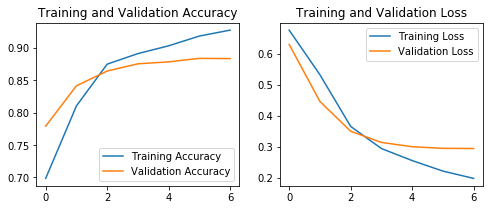

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
result = model.evaluate(test_x, test_y)

25000/25000 [==============================] - 1s 37us/sample - loss: 0.3158 - accuracy: 0.8692
